# Load modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]
Virtual memory usage - total: 252 GB / available: 231 GB / percent used: 8.4 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(0,60)
lonlim=(30,140)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'

# Check the differences between ERA-Interim and model for Eastward Near-Surface Wind

## Load first member

In [3]:
realization = 'r1i1p1f1'
var = 'uas'
table = 'Amon'

# Load historical
uas = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
uas_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_SF/*/u10.*.asmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).u10.sel(time=period).load()

## Regrid

In [4]:
regridder = xe.Regridder(uas_era, uas, 'bilinear', periodic=True, reuse_weights=True)
uas_era_regrid = regridder(uas_era)

Reuse existing file: bilinear_241x480_143x144_peri.nc


## Select zone

In [5]:
uas = uas.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
uas_era_regrid = uas_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Compute clim

In [6]:
uas_clim = uas.mean('time')
uas_era_regrid_clim = uas_era_regrid.mean('time')

In [7]:
uas_bias = uas_clim-uas_era_regrid_clim

In [8]:
uas_bias.min().values

array(-4.50381991)

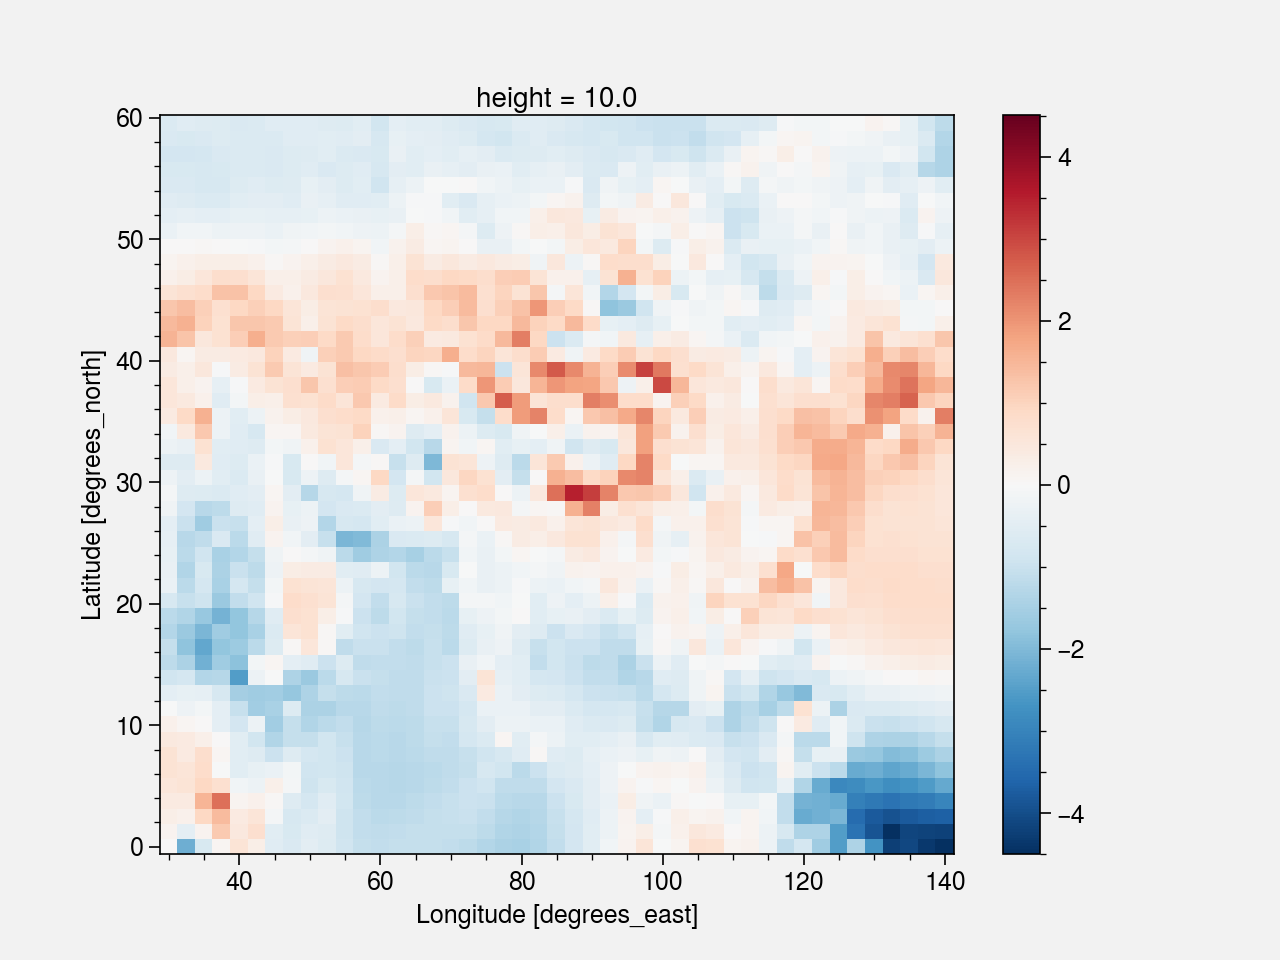

In [9]:
uas_bias.plot(robust=False)

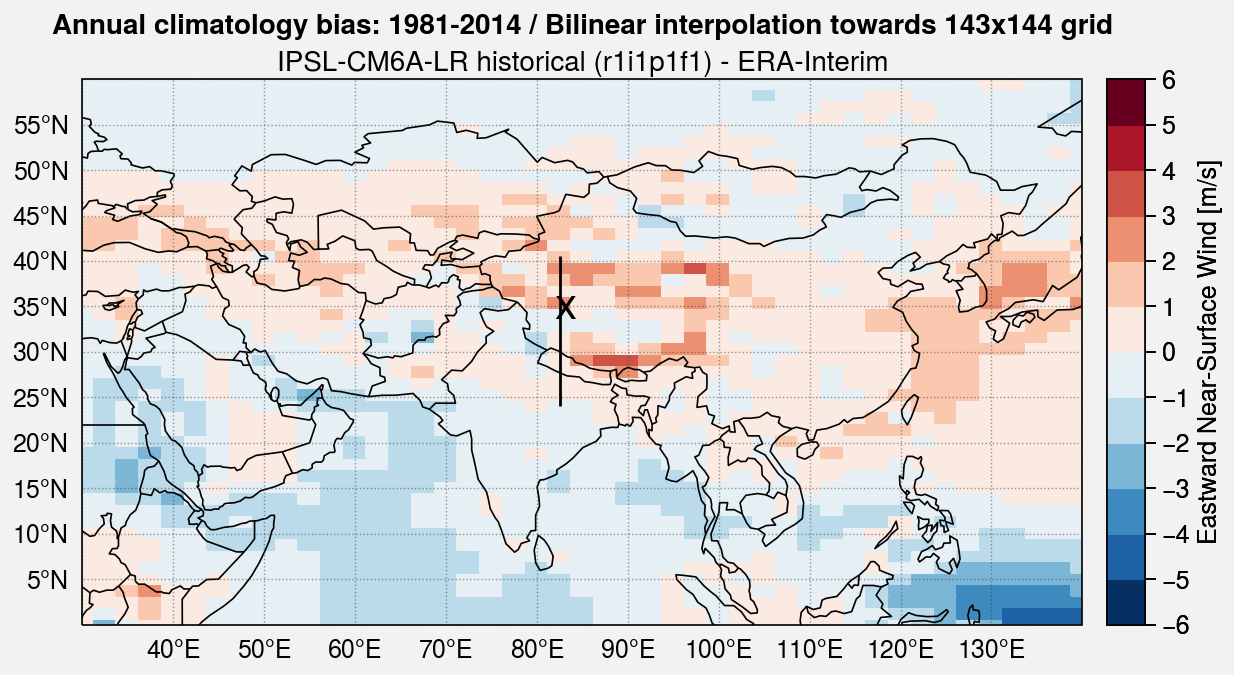

In [14]:
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

dx=2.5
dy=1.2676

f, axs = plot.subplots(proj='cyl', ncols=1, nrows=1, axwidth=5)

m = axs[0].pcolormesh(uas_bias, cmap='RdBu_r', levels=plot.arange(-6,6,1))
axs[0].format(title='IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim')

f.colorbar(m, label='Eastward Near-Surface Wind [m/s]')


# Add box   
axs[0].add_patch(mpatches.Rectangle(
    xy=[82.5, 24.084507], width=0, height=40.56338-24.084507,
    transform=ccrs.PlateCarree(), fill=False
))
axs[0].text(82.5-dx/4, 34.225353-dy/2, 'x', fontsize=16, 
#             horizontalalignment='center', verticalalignment='center'
           )


axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Annual climatology bias: 1981-2014 / Bilinear interpolation towards 143x144 grid",
    lonlines=10, latlines=5, abc=False, latlim=latlim, lonlim=lonlim
)

var = 'ua'
# f.save('img/'+var+'/uas_IPSL_CMIP6-ERAI_bias_ext.png')
# f.save('img/'+var+'/uas_IPSL_CMIP6-ERAI_bias_ext.pdf')

# Load surface pressure for masking ERA-Interim
http://clipc-services.ceda.ac.uk/dreq/u/8c9504d28596e05586c8e193082ac617.html

In [15]:
realization = 'r1i1p1f1'
var = 'ps'
table = 'Amon'

# Load historical
ps = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var]

# ERA-Interim
ps_era = xr.open_mfdataset(
    "/data/mlalande/ERAI/sp/sp_ERAI_*.nc",
    combine='by_coords', parallel=True
).sp.sel(time=period).load()

In [16]:
ps_era_regrid = regridder(ps_era)

ps = ps.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ps_era_regrid = ps_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

# Get the minimum pressure (finally not used)
ps_min = ps.min('time')
ps_era_regrid_min = ps_era_regrid.min('time')

# Load Eastward Wind

In [17]:
var ='ua'

ua = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords', parallel=True
).sel(time=period)[var].load()

ua_era = xr.open_mfdataset(
    '/bdd/ERAI/NETCDF/GLOBAL_075/1xmonthly/AN_PL/*/u.*.apmei.GLOBAL_075.nc',
    combine='by_coords', parallel=True
).u.sel(time=period).load()

## Regrid horizontal

In [18]:
# Regrid horizontal
ua_era_regrid = regridder(ua_era)

## Select zone

In [19]:
ua = ua.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()
ua_era_regrid = ua_era_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])).load()

## Mask vertical values > ps

In [20]:
ua_era_regrid_masked = ua_era_regrid.where(ua_era_regrid.level <= ps_era_regrid/100)

## Regrid vertical

In [21]:
ua_era_regrid_masked_v = ua_era_regrid_masked.interp(level=(ua.plev.values/100), method='linear')

## Compute climatologie

In [22]:
ua_clim = ua.mean('time', skipna=False).load()
ua_era_regrid_masked_clim = ua_era_regrid_masked.mean('time', skipna=False).load()
ua_era_regrid_masked_v_clim = ua_era_regrid_masked_v.mean('time', skipna=False).load()

ua_bias = ua_clim-ua_era_regrid_masked_v_clim.values

In [23]:
ua_clim.sel(lon=82.5).min()

<xarray.DataArray 'ua' ()>
array(-13.374127, dtype=float32)
Coordinates:
    lon      float32 82.5

In [24]:
ua_clim.sel(lon=82.5).max()

<xarray.DataArray 'ua' ()>
array(36.900753, dtype=float32)
Coordinates:
    lon      float32 82.5

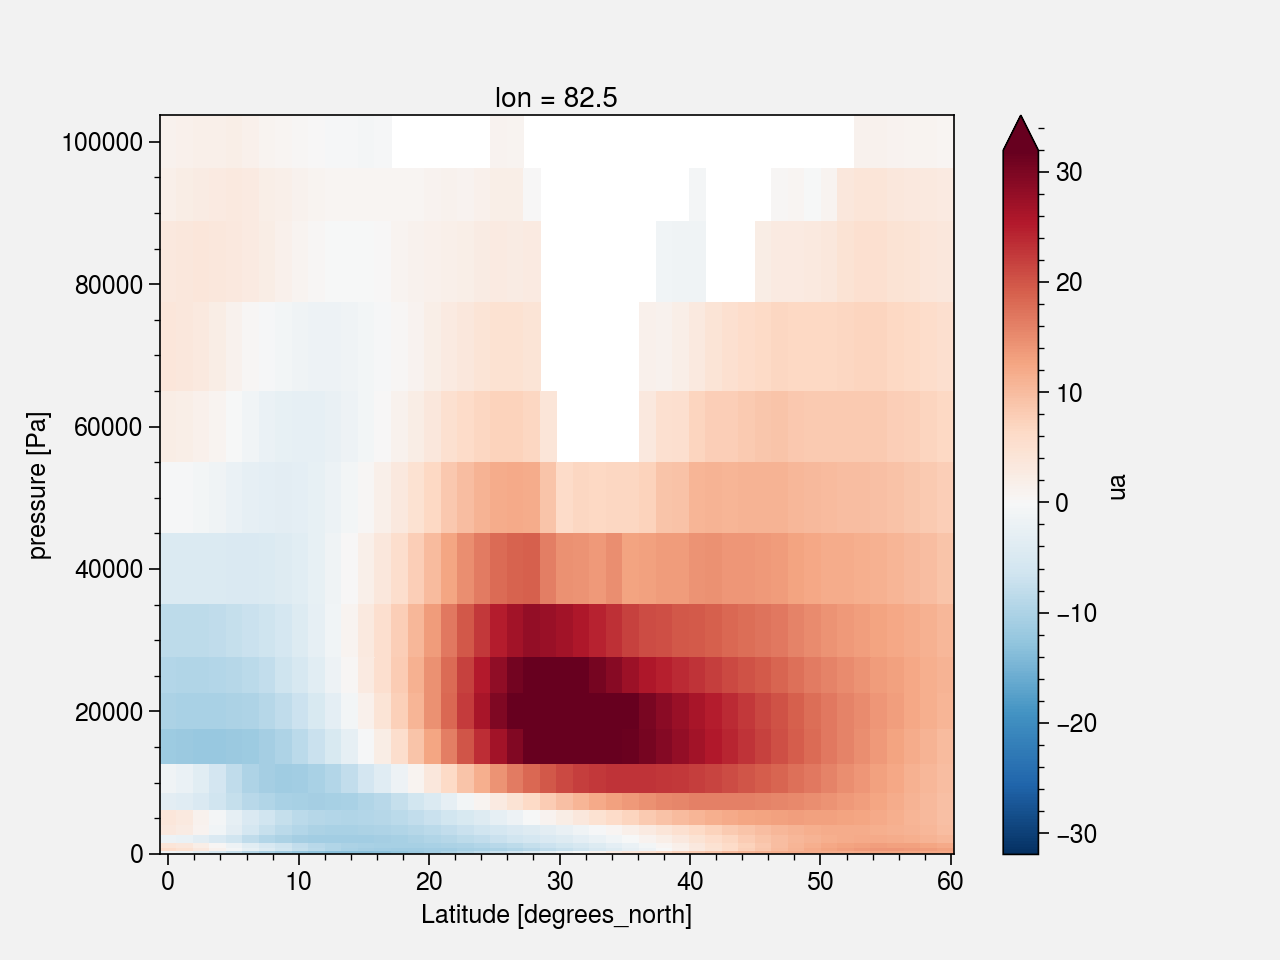

In [25]:
ua_clim.sel(lon=82.5).plot(robust=True)

In [26]:
ua_bias.sel(lon=82.5).max()

<xarray.DataArray 'ua' ()>
array(16.03866039)
Coordinates:
    lon      float32 82.5

In [27]:
ua_bias.sel(lon=82.5).min()

<xarray.DataArray 'ua' ()>
array(-9.58936386)
Coordinates:
    lon      float32 82.5

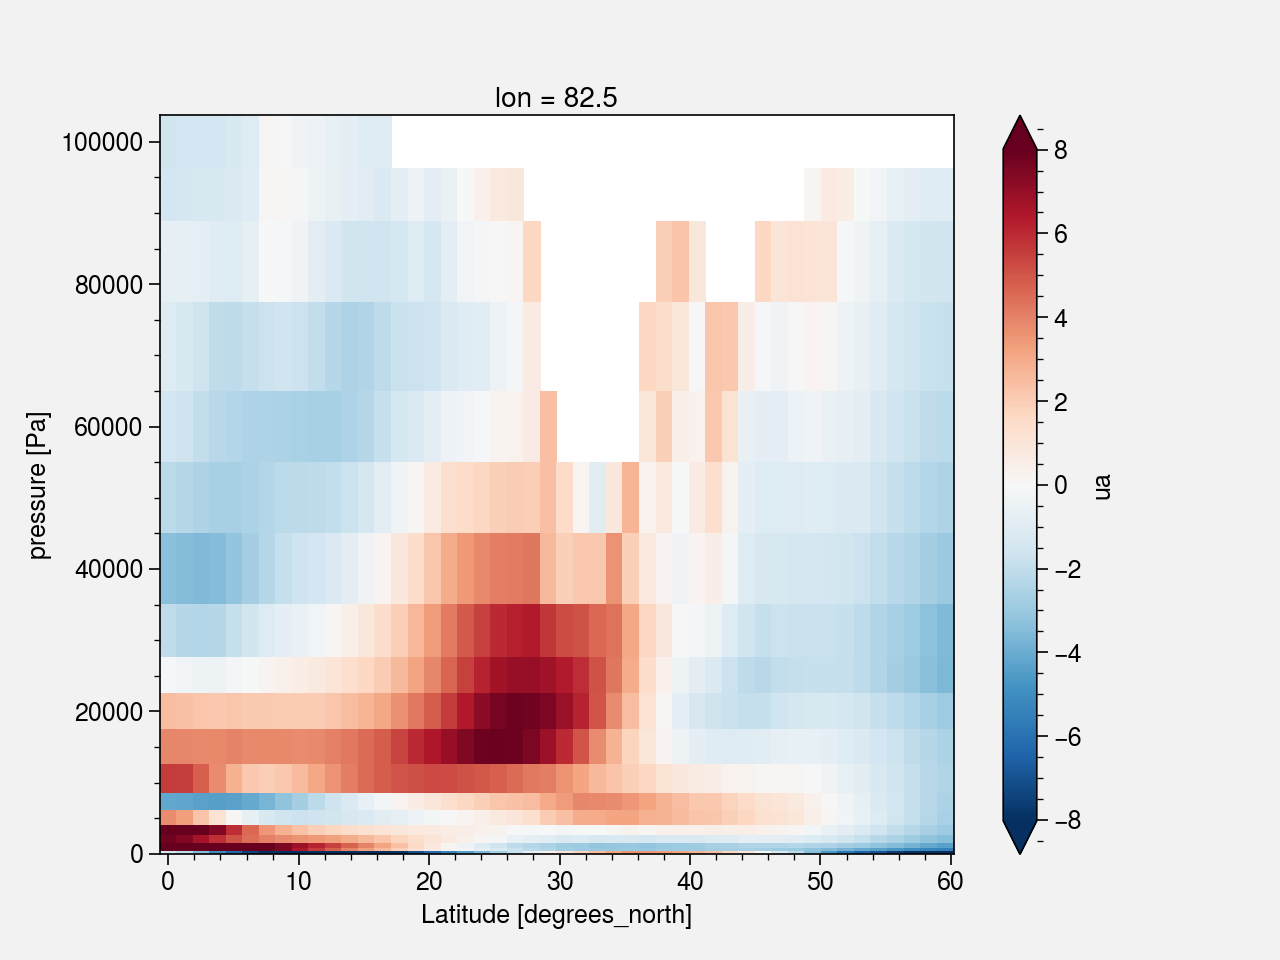

In [28]:
ua_bias.sel(lon=82.5).plot(robust=True)

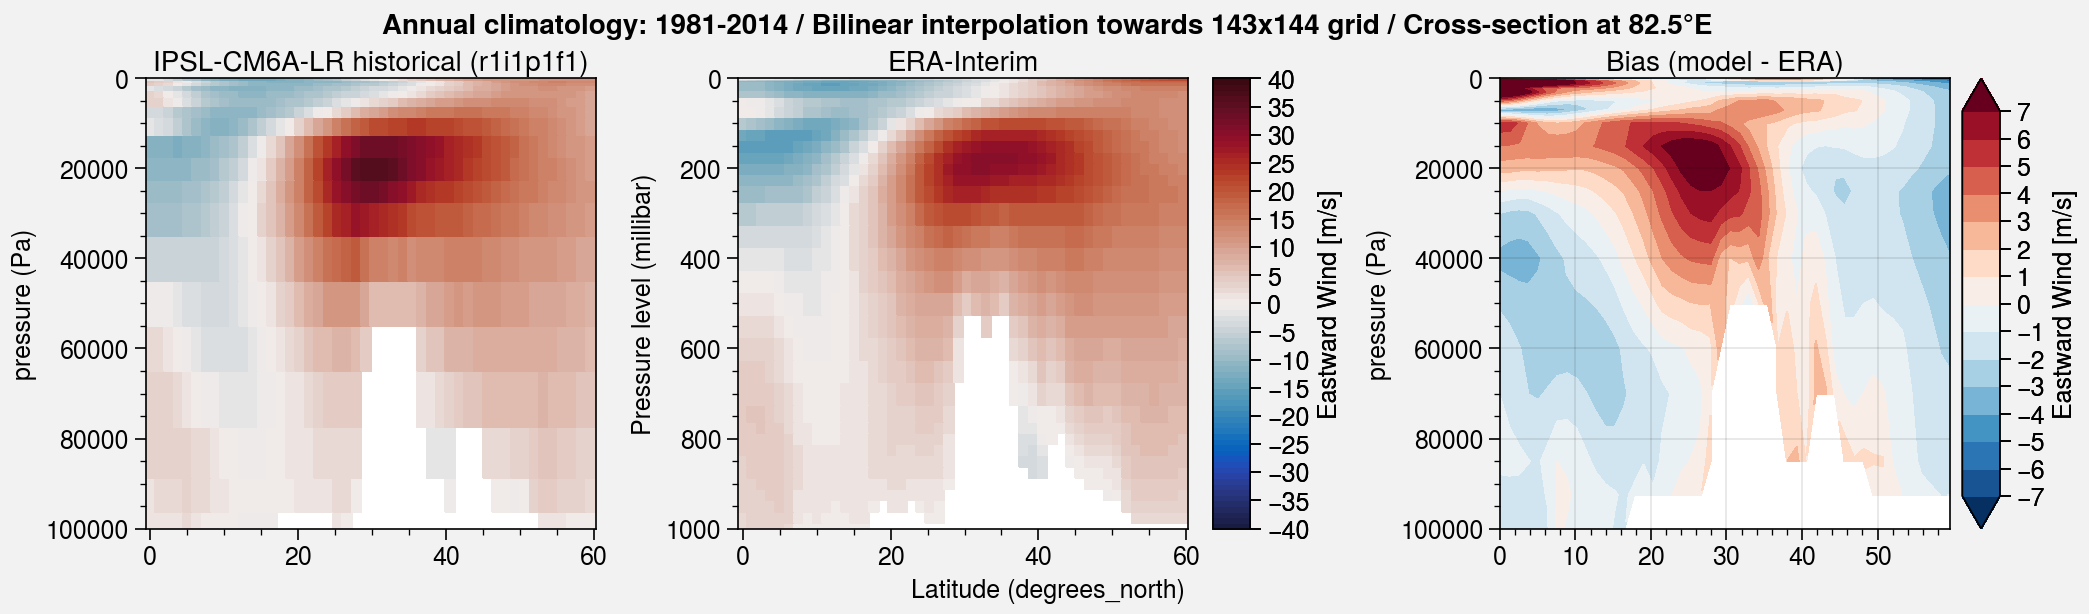

In [29]:
#Check colorbars 
levels = plot.arange(-40,40,1)
extend='neither'
cmap='Spectral'
cmap='Balance'


f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ua_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ua_era_regrid_masked_clim.sel(lon=82.5), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Eastward Wind [m/s]')

# Bias
m2 = axs[2].contourf(ua_bias.sel(lon=82.5), cmap='BuRd', levels=plot.arange(-7,7,1), extend='both')
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Eastward Wind [m/s]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 82.5°E"
)

# f.save('img/ua/slice_lon_82_5_ua_pcolormesh_ext.png')
# f.save('img/ua/slice_lon_82_5_ua_pcolormesh_ext.pdf')

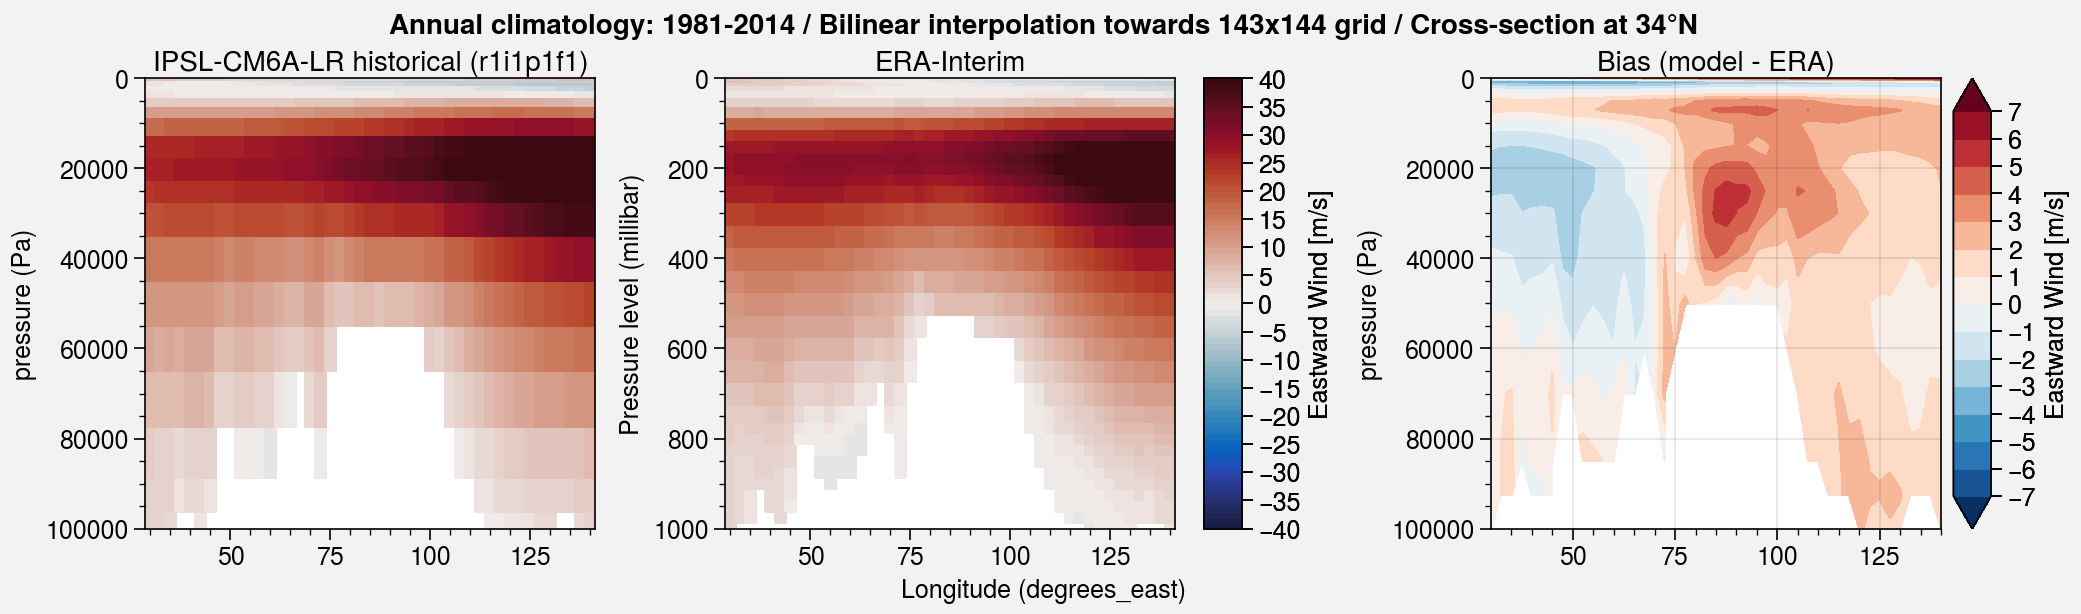

In [30]:
#Check colorbars 
levels = plot.arange(-40,40,1)
extend='neither'
cmap='Spectral'
cmap='Balance'

f, axs = plot.subplots(nrows=1, ncols=3, sharey=0)

# Model
m1 = axs[0].pcolormesh(ua_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[0].format(ylim=(100000,0), title='IPSL-CM6A-LR historical (r1i1p1f1)')

# ERA-Interim
axs[1].pcolormesh(ua_era_regrid_masked_clim.sel(lat=34.225353), cmap=cmap, levels=levels, norm='midpoint', extend=extend)
axs[1].format(ylim=(1000,0), title='ERA-Interim')
axs[1].colorbar(m1, label='Eastward Wind [m/s]')

# Bias
m2 = axs[2].contourf(ua_bias.sel(lat=34.225353), cmap='BuRd', levels=plot.arange(-7,7,1), extend='both')
axs[2].format(ylim=(100000,0), title='Bias (model - ERA)')
axs[2].colorbar(m2, label='Eastward Wind [m/s]')


axs.format(
    suptitle="Annual climatology: 1981-2014 / Bilinear interpolation towards 143x144 grid / Cross-section at 34°N"
)

# f.save('img/ua/slice_lat_34_ua_pcolormesh_ext.png')
# f.save('img/ua/slice_lat_34_ua_pcolormesh_ext.pdf')

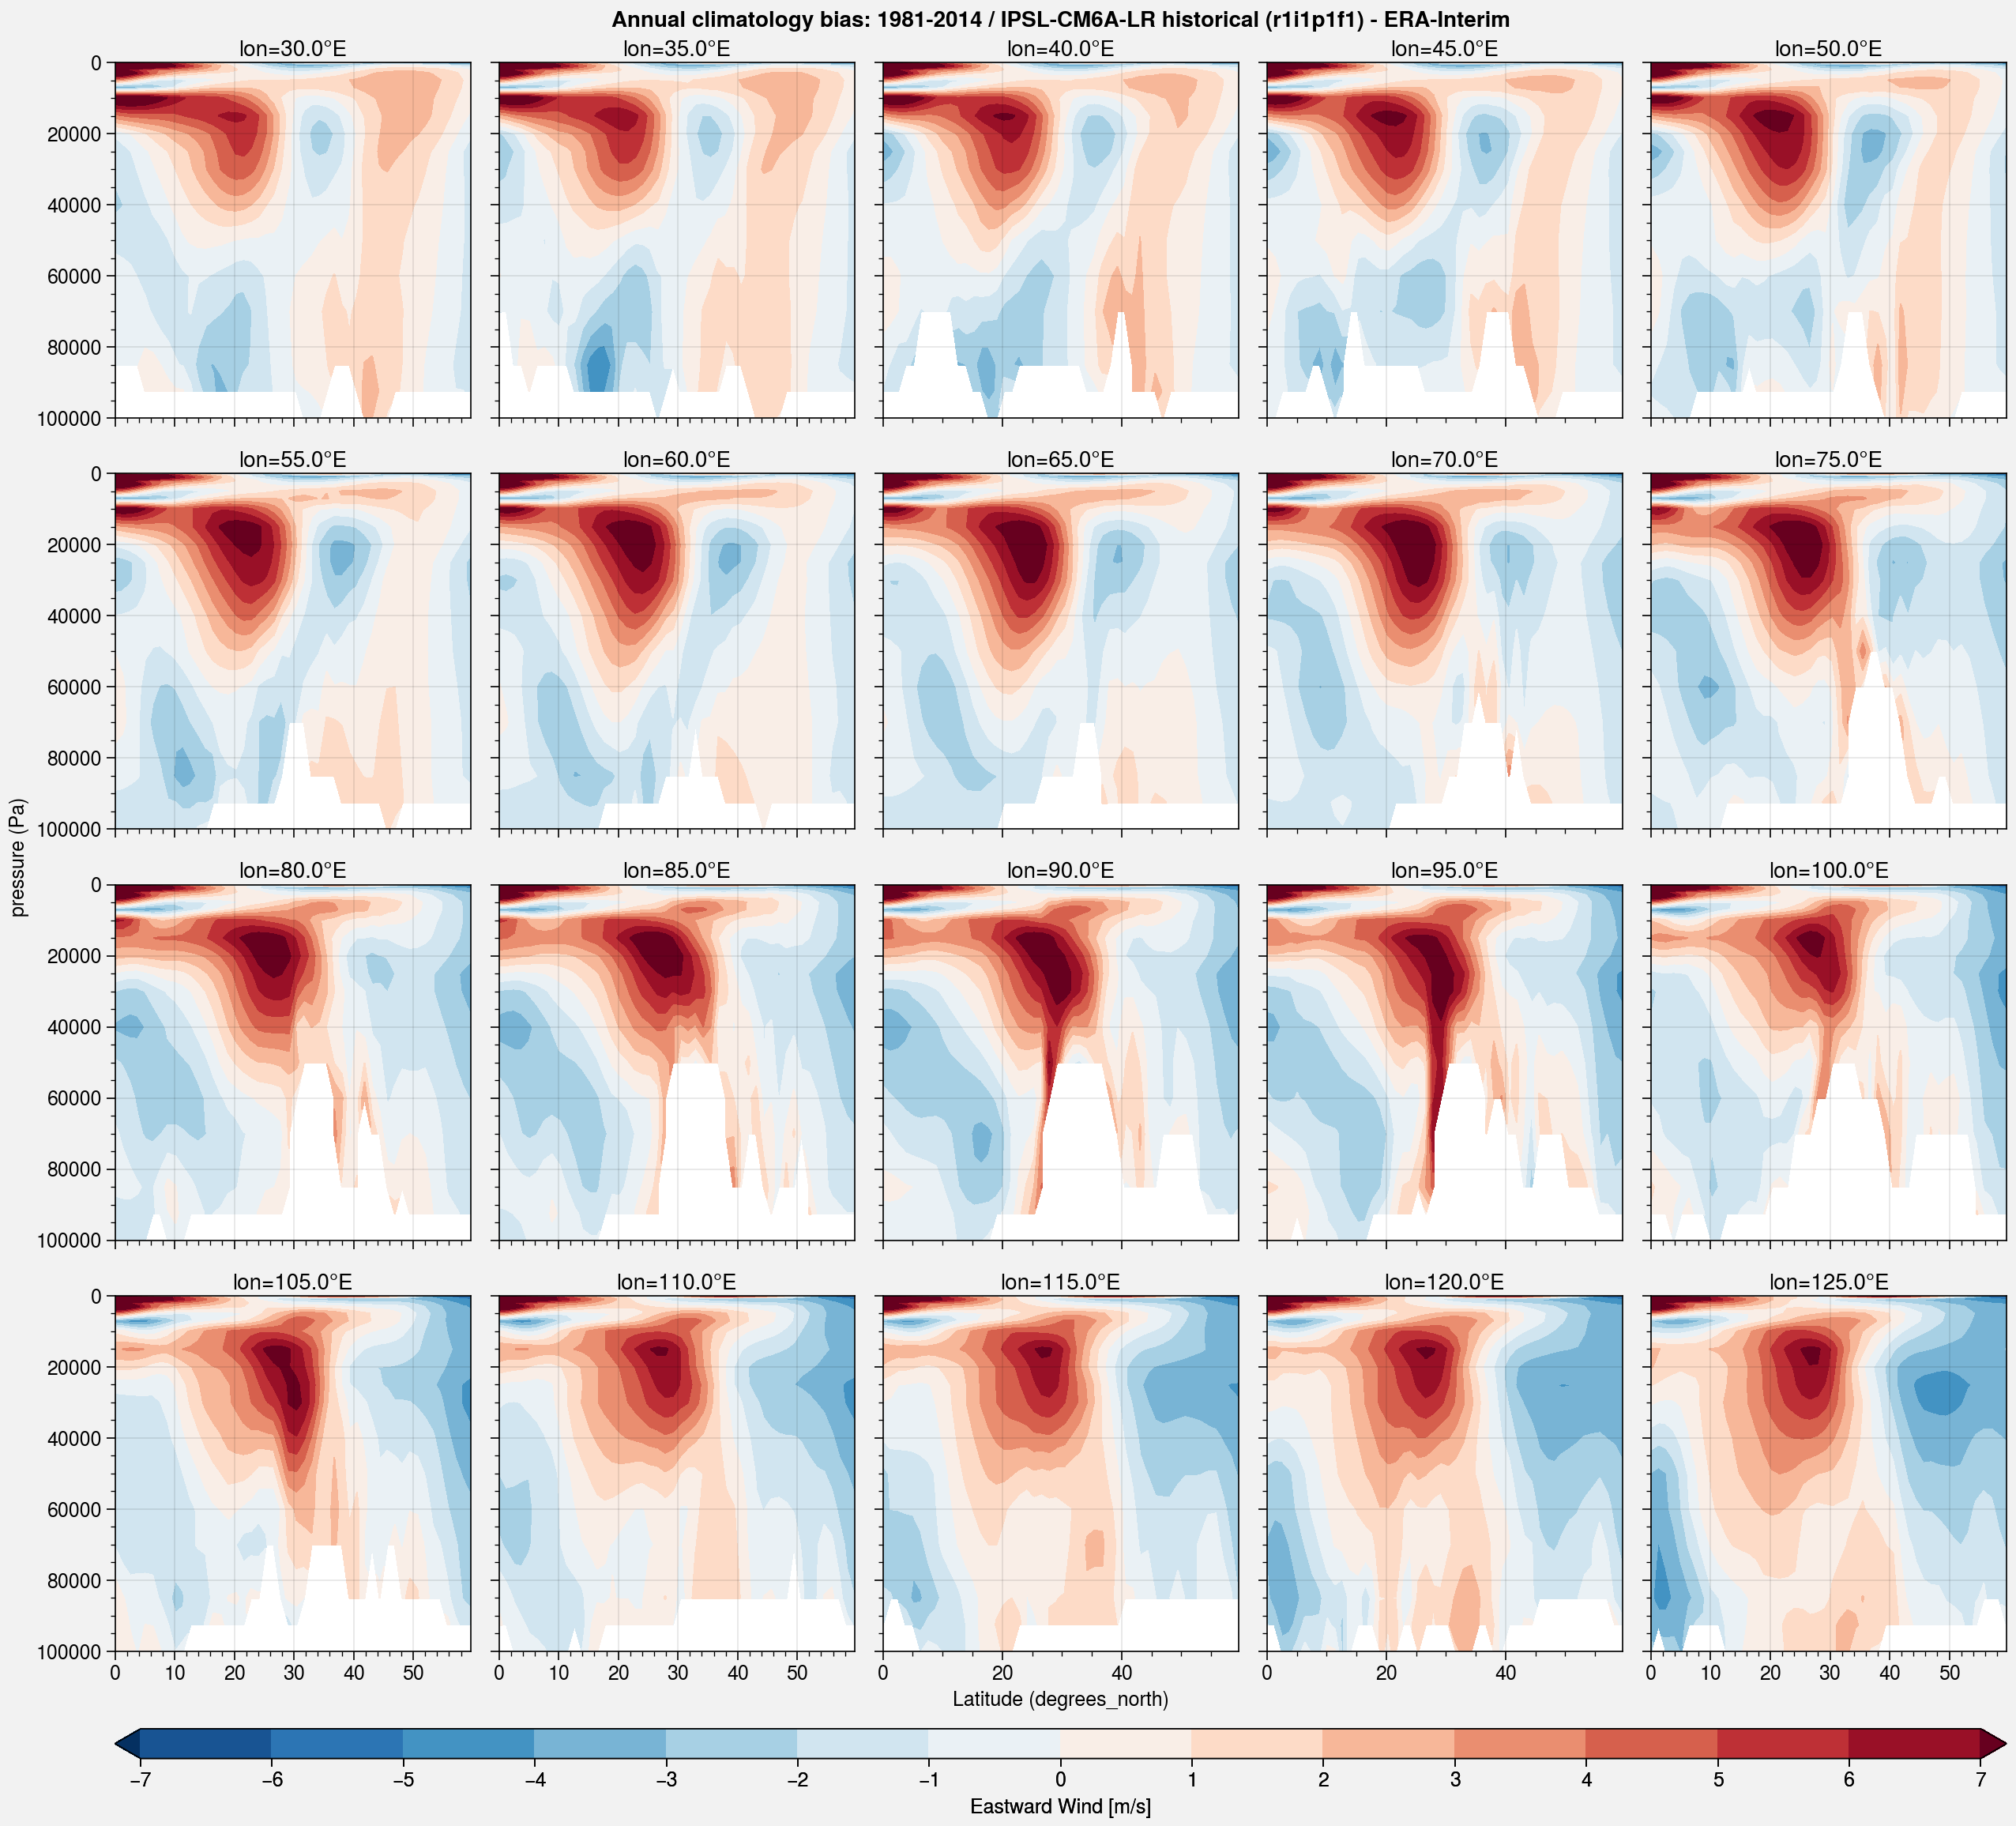

In [35]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=4, ncols=5)

for i, ax in enumerate(axs):
    m = ax.contourf(ua_bias[:,:,0:-1:2].isel(lon=i), cmap='BuRd', levels=plot.arange(-7,7,1), extend=extend)
    ax.format(ylim=(100000,0), title='lon='+str(ua_bias[:,:,0:-1:2].isel(lon=i).lon.values)+'°E')

f.colorbar(m2, label='Eastward Wind [m/s]', loc='b')


axs.format(
    suptitle="Annual climatology bias: 1981-2014 / IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim"
)

# f.save('img/ua/slices_lon_ua_pcolormesh_ext.png')
# f.save('img/ua/slices_lon_ua_pcolormesh_ext.pdf')

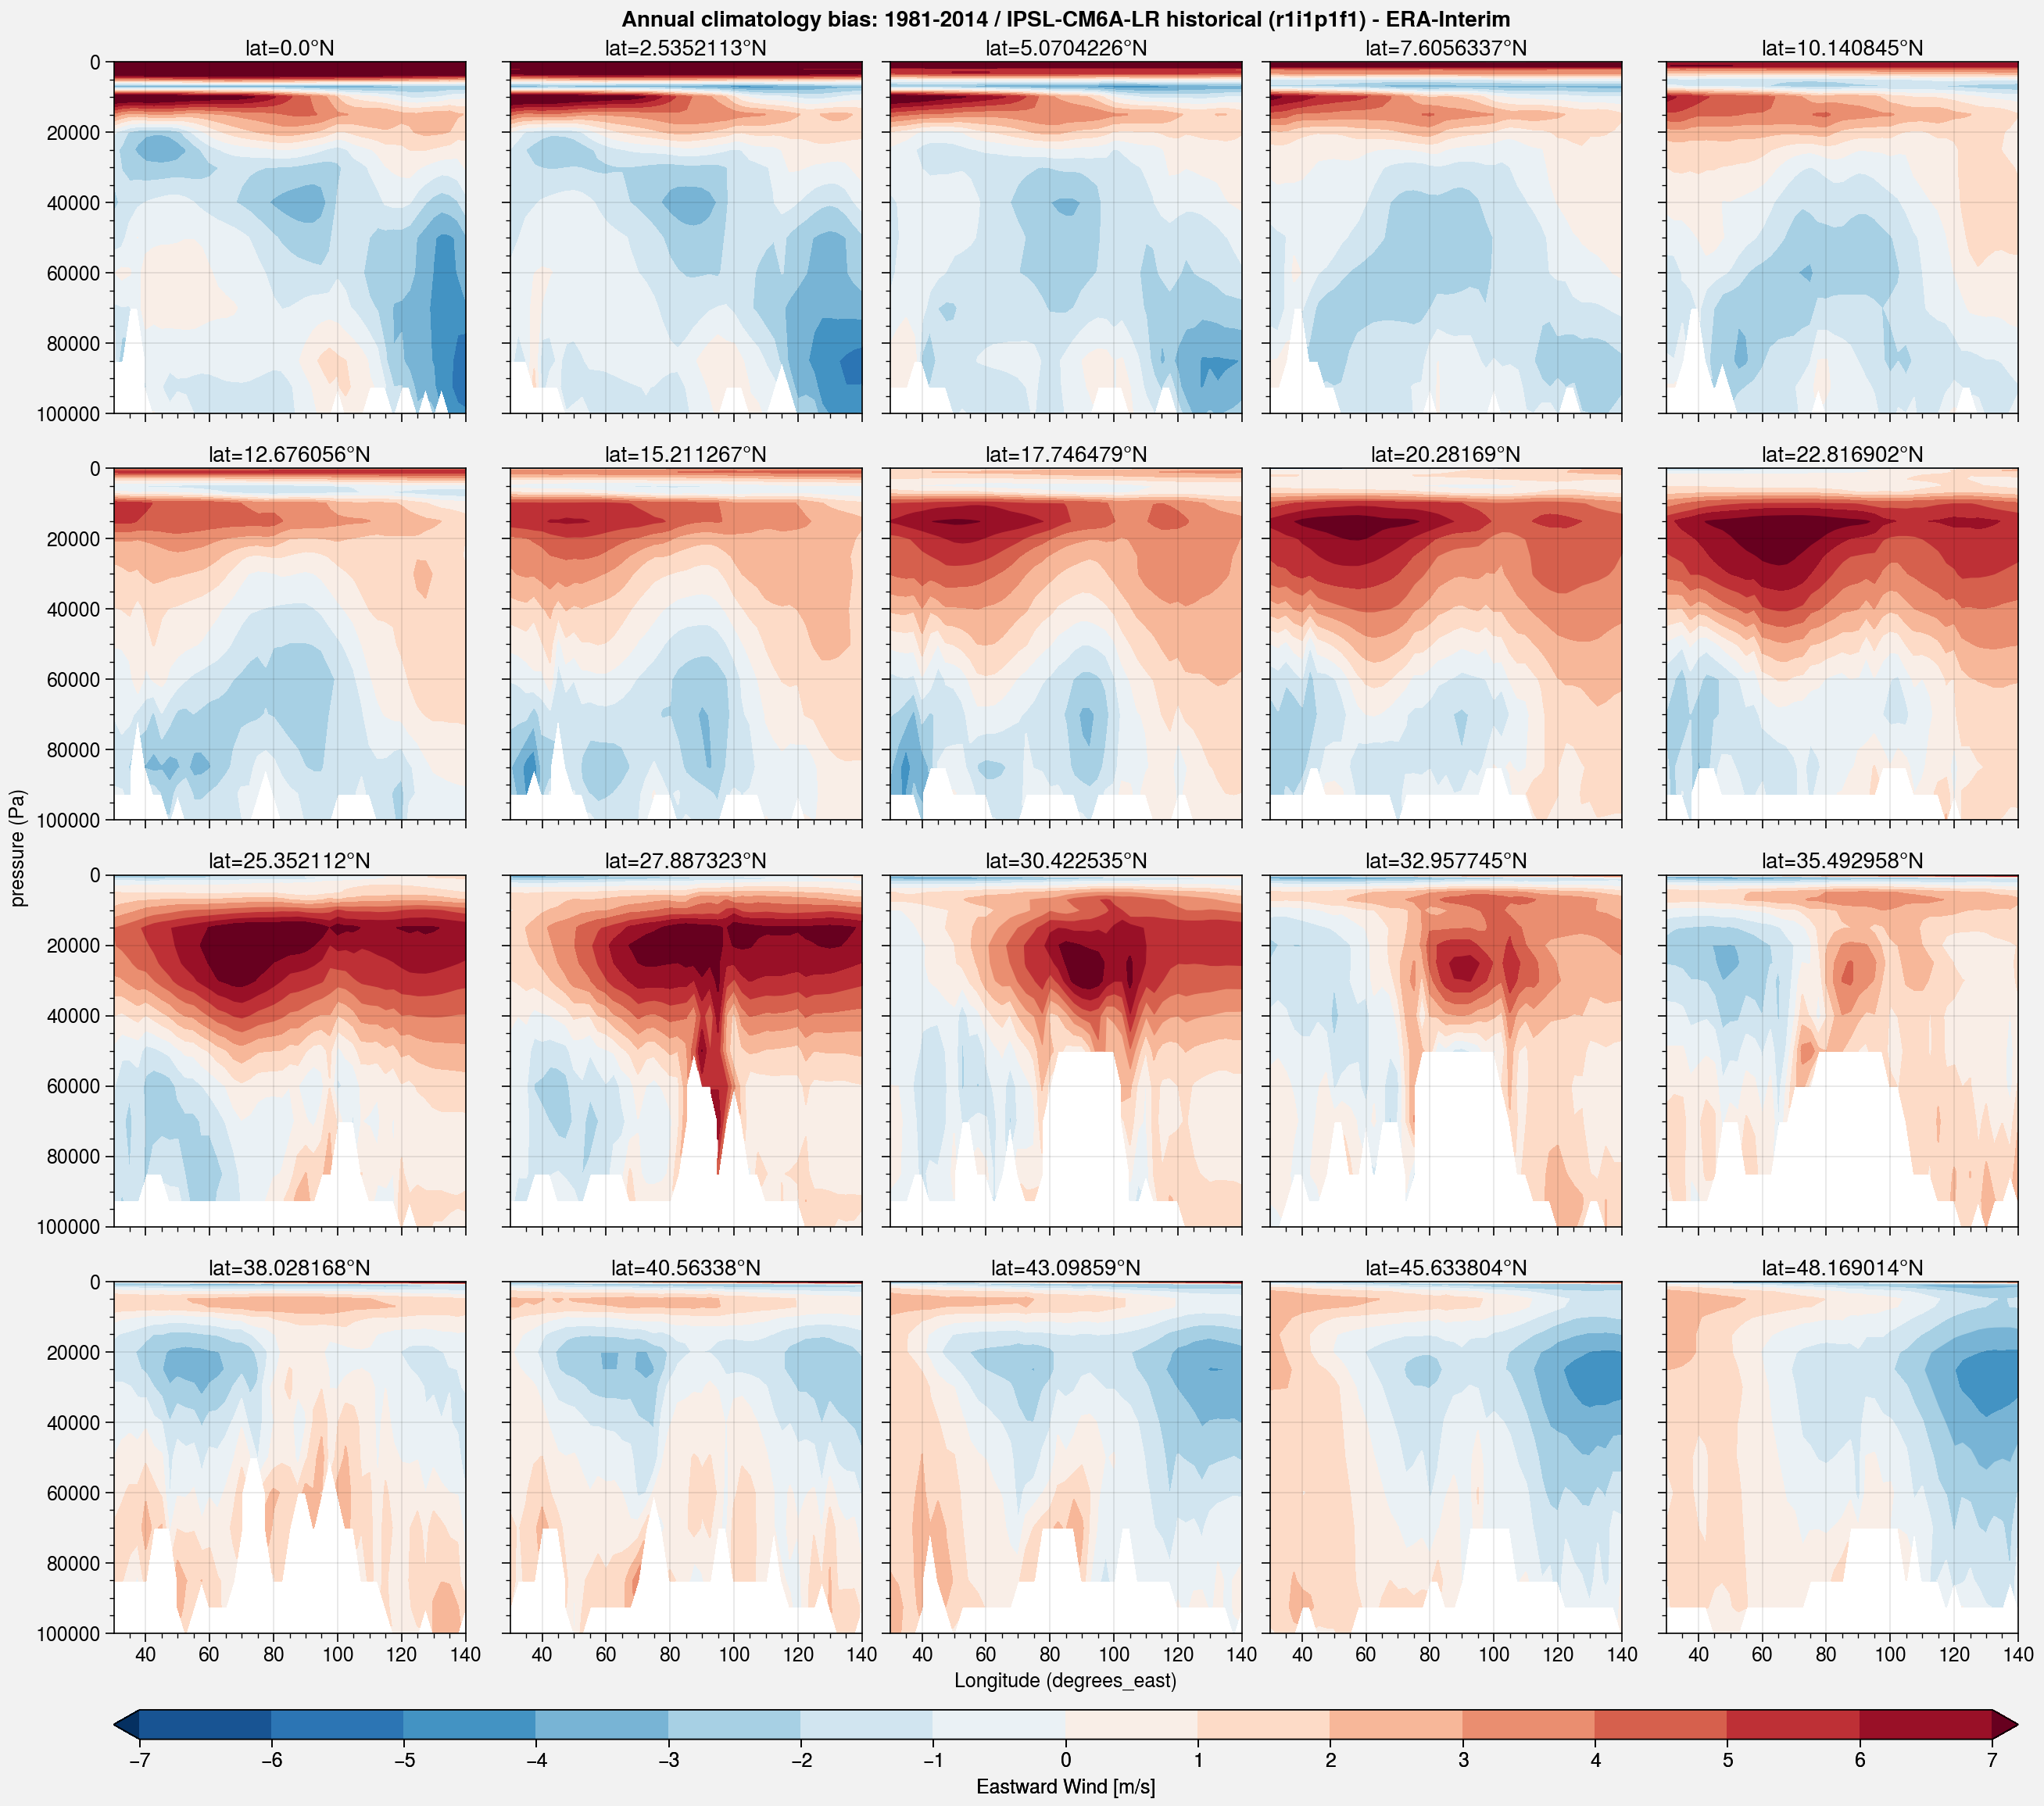

In [36]:
#Check colorbars 
levels = plot.arange(-60,30,1)
extend='both'
cmap='Spectral'

f, axs = plot.subplots(nrows=4, ncols=5)

for i, ax in enumerate(axs):
    m = ax.contourf(ua_bias[:,0:-1:2,:].isel(lat=i), cmap='BuRd', levels=plot.arange(-7,7,1), extend=extend)
    ax.format(ylim=(100000,0), title='lat='+str(ua_bias[:,0:-1:2,:].isel(lat=i).lat.values)+'°N')

f.colorbar(m2, label='Eastward Wind [m/s]', loc='b')


axs.format(
    suptitle="Annual climatology bias: 1981-2014 / IPSL-CM6A-LR historical (r1i1p1f1) - ERA-Interim"
)

# f.save('img/ua/slices_lat_ua_pcolormesh_ext.png')
# f.save('img/ua/slices_lat_ua_pcolormesh_ext.pdf')